_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 3

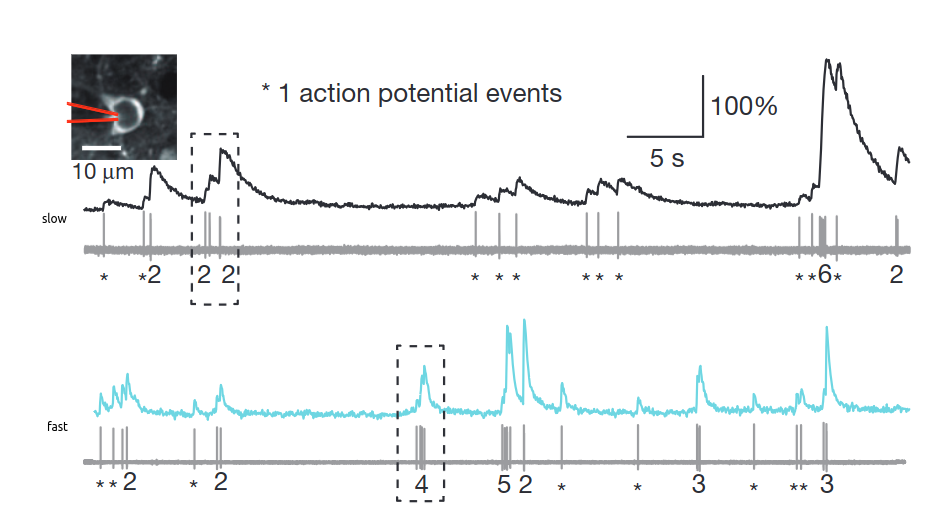

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-07 19:21:31CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.30.0

sklearn: 1.6.1

scipy     : 1.15.2
numpy     : 2.2.4
matplotlib: 3.10.1
sys       : 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:43:39) [Clang 11.1.0 ]
pandas    : 2.2.3
seaborn   : 0.13.2

Watermark: 2.5.0



In [6]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [7]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0).values
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0).values
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0).values
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0).values
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# spike dataframe
# ogb_spikes.head()
# ogb_calcium.head()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

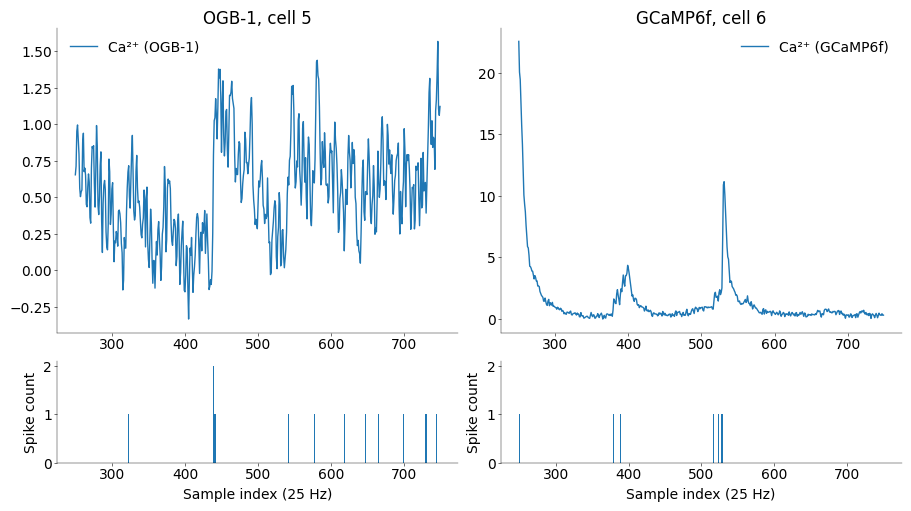

In [8]:
# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------

# downsample calcium: 100->25 Hz (q=4), zero_phase to avoid lag
ogb_cal_ds = signal.decimate(ogb_calcium, q=4, axis=0, ftype="iir", zero_phase=True)
gcamp_cal_ds = signal.decimate(gcamp_calcium, q=4, axis=0, ftype="iir", zero_phase=True)


# downsample spikes: 100->25Hz
def bin_spikes(arr, q=4):
    L = (arr.shape[0] // q) * q
    return arr[:L].reshape(-1, q, arr.shape[1]).sum(axis=1)


ogb_spk_ds = bin_spikes(ogb_spikes)
gcamp_spk_ds = bin_spikes(gcamp_spikes)

# pick cells 5 and 6
cell_ogb = ogb_cal_ds[:, 4]
spk_ogb = ogb_spk_ds[:, 4]
cell_gcam = gcamp_cal_ds[:, 5]
spk_gcam = gcamp_spk_ds[:, 5]

# e.g. zoom from 10 s to 30 s → samples 10*25=250 to 30*25=750
i0, i1 = 250, 750
n_ds = ogb_cal_ds.shape[0]
idx = np.arange(n_ds)

fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), gridspec_kw={"height_ratios": [3, 1]}, layout="constrained"
)
# Top-left: OGB Ca + spikes
ax_ogb = axs[0, 0]
ax_ogb.plot(idx[i0:i1], cell_ogb[i0:i1], label="Ca²⁺ (OGB-1)")
ax_ogb.set_title("OGB-1, cell 5")
ax_ogb.legend()

# Bottom-left: spike histogram
ax_ogb_hist = axs[1, 0]
ax_ogb_hist.bar(idx[i0:i1], spk_ogb[i0:i1], width=1.0)
ax_ogb_hist.set_xlabel("Sample index (25 Hz)")
ax_ogb_hist.set_ylabel("Spike count")

# Top-right: GCaMP Ca
ax_gcam = axs[0, 1]
ax_gcam.plot(idx[i0:i1], cell_gcam[i0:i1], label="Ca²⁺ (GCaMP6f)")
ax_gcam.set_title("GCaMP6f, cell 6")
ax_gcam.legend()

# Bottom-right: GCaMP spike histogram
ax_gcam_hist = axs[1, 1]
ax_gcam_hist.bar(idx[i0:i1], spk_gcam[i0:i1], width=1.0)
ax_gcam_hist.set_xlabel("Sample index (25 Hz)")
ax_gcam_hist.set_ylabel("Spike count")

plt.show()

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [9]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Compute deconvolution of calcium trace using simple AR(1) inversion:
        ca[t] = exp(-dt/tau)*ca[t-1] + sp[t]
    so sp[t] = ca[t] - alpha*ca[t-1], clipped at zero.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------

    alpha = np.exp(-dt / tau)
    sp_hat = np.zeros_like(ca)
    sp_hat[1:] = ca[1:] - alpha * ca[:-1]
    sp_hat = np.clip(sp_hat, 0, None)  # no negative rates

    return sp_hat

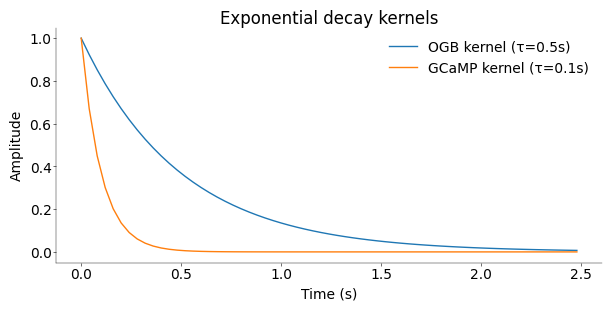

In [10]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------

# Parameters
dt = 1 / 25.0  # sampling interval (s)
tau_ogb = 0.5
tau_gcamp = 0.1

# Compute kernels
t_max = 5 * max(tau_ogb, tau_gcamp)
t = np.arange(0, t_max, dt)
h_ogb = np.exp(-t / tau_ogb)
h_gcamp = np.exp(-t / tau_gcamp)

# Plot kernels
plt.figure(figsize=(6, 3))
plt.plot(t, h_ogb, label=f"OGB kernel (τ={tau_ogb}s)")
plt.plot(t, h_gcamp, label=f"GCaMP kernel (τ={tau_gcamp}s)")
plt.title("Exponential decay kernels")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

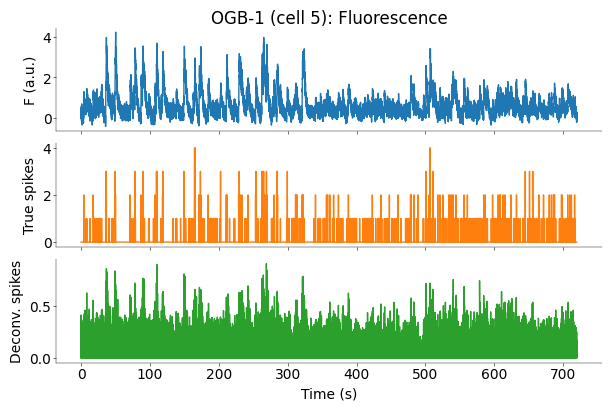

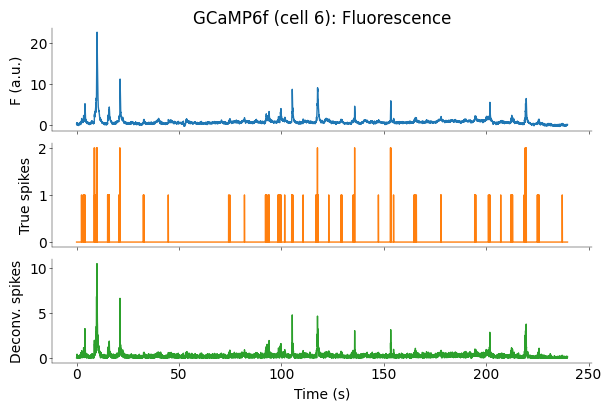

In [11]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------
# Parameters
dt = 1 / 25.0  # sampling interval (s)
tau_ogb = 0.5
tau_gcamp = 0.1

# Compute kernels
t_max = 5 * max(tau_ogb, tau_gcamp)
t = np.arange(0, t_max, dt)
h_ogb = np.exp(-t / tau_ogb)
h_gcamp = np.exp(-t / tau_gcamp)

# Deconvolve example cells (pre-defined in notebook)
sp_hat_ogb = deconv_ca(cell_ogb, tau_ogb, dt)
sp_hat_gcam = deconv_ca(cell_gcam, tau_gcamp, dt)

# Time axes
t_ogb = np.arange(len(cell_ogb)) / 25.0
t_gcamp = np.arange(len(cell_gcam)) / 25.0

# Zoom window: 10–30 s
i0, i1 = np.searchsorted(t_ogb, [10, 30])
j0, j1 = np.searchsorted(t_gcamp, [10, 30])
fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

# Row 1: raw Ca trace
axs[0].plot(t_ogb, cell_ogb, color="tab:blue")
axs[0].set_ylabel("F (a.u.)")
axs[0].set_title("OGB-1 (cell 5): Fluorescence")
axs[0].label_outer()  # hide x-ticklabels here

# Row 2: true spikes
axs[1].plot(t_ogb[:-1], spk_ogb, color="tab:orange")
axs[1].set_ylabel("True spikes")
axs[1].label_outer()

# Row 3: deconvolved spikes
axs[2].plot(t_ogb, sp_hat_ogb, color="tab:green")
axs[2].set_ylabel("Deconv. spikes")
axs[2].set_xlabel("Time (s)")

plt.show()

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamp Cell

# Row 1: raw Ca trace
axs[0].plot(t_gcamp, cell_gcam, color="tab:blue")
axs[0].set_ylabel("F (a.u.)")
axs[0].set_title("GCaMP6f (cell 6): Fluorescence")
axs[0].label_outer()

# Row 2: true spikes
axs[1].plot(t_gcamp[:-1], spk_gcam, color="tab:orange")
axs[1].set_ylabel("True spikes")
axs[1].label_outer()

# Row 3: deconvolved spikes
axs[2].plot(t_gcamp, sp_hat_gcam, color="tab:green")
axs[2].set_ylabel("Deconv. spikes")
axs[2].set_xlabel("Time (s)")

plt.show()

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [17]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
#!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

In [16]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------

# Down-sample calcium & spikes to 25 Hz
q = 4
ogb_cal_ds = signal.decimate(ogb_calcium, q, axis=0, ftype="iir", zero_phase=True)
gcamp_cal_ds = signal.decimate(gcamp_calcium, q, axis=0, ftype="iir", zero_phase=True)


def bin_spikes(arr, q):
    L = (arr.shape[0] // q) * q
    return arr[:L].reshape(-1, q, arr.shape[1]).sum(axis=1)


ogb_spk_ds = bin_spikes(ogb_spikes, q)
gcamp_spk_ds = bin_spikes(gcamp_spikes, q)

# Pick ROIs
cell_ogb = ogb_cal_ds[:, 4]  # OGB-1, cell 5
cell_gcam = gcamp_cal_ds[:, 5]  # GCaMP6f, cell 6
spk_ogb = ogb_spk_ds[:, 4]
spk_gcam = gcamp_spk_ds[:, 5]

# 4) Run fast-oopsi
dt = 1 / 25.0  # seconds per frame at 25 Hz
# returns inferred spike train `n_*` and reconstructed Ca trace `C_*`
n_ogb, C_ogb = oopsi.fast(cell_ogb, dt, iter_max=6, update=True)
n_gcamp, C_gcamp = oopsi.fast(cell_gcam, dt, iter_max=6, update=True)


# 5) Time axes & zoom window
t_ogb = np.arange(len(cell_ogb)) / 25.0
t_gcamp = np.arange(len(cell_gcam)) / 25.0
i0, i1 = np.searchsorted(t_ogb, [10, 30])
j0, j1 = np.searchsorted(t_gcamp, [10, 30])

AttributeError: 'function' object has no attribute 'spsolve'

In [ ]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

# OGB Cell

fig, axs = plt.subplots(
    3, 1,
    figsize=(6, 4),
    gridspec_kw={'height_ratios': [1, 1, 1], 'hspace': 0}
)

# Row 1: raw Ca trace
axs[0].plot(t_ogb, cell_ogb, color="tab:blue")
axs[0].set_ylabel("F (a.u.)")
axs[0].set_title("OGB-1 (cell 5): Fluorescence")
axs[0].label_outer()

# Row 2: true spikes
axs[1].plot(t_ogb[:-1], spk_ogb, color="tab:orange")
axs[1].set_ylabel("True spikes")
axs[1].label_outer()

# Row 3: inferred spikes
axs[2].plot(t_ogb, n_ogb, color="tab:green")
axs[2].set_ylabel("Inferred spikes")
axs[2].set_xlabel("Time (s)")

plt.show()

# GCamP Cell

fig, axs = plt.subplots(
    3, 1,
    figsize=(6, 4),
    gridspec_kw={'height_ratios': [1, 1, 1], 'hspace': 0}
)

# Row 1: raw Ca trace
axs[0].plot(t_gcamp, cell_gcam, color="tab:blue")
axs[0].set_ylabel("F (a.u.)")
axs[0].set_title("GCaMP6f (cell 6): Fluorescence")
axs[0].label_outer()

# Row 2: true spikes
axs[1].plot(t_gcamp[:-1], spk_gcam, color="tab:orange")
axs[1].set_ylabel("True spikes")
axs[1].label_outer()

# Row 3: inferred spikes
axs[2].plot(t_gcamp, n_gcamp, color="tab:green")
axs[2].set_ylabel("Inferred spikes")
axs[2].set_xlabel("Time (s)")

plt.show()

NameError: name 'plt' is not defined

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [ ]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------

In [ ]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

In [ ]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
